# SLC

## Imports

In [1]:
import os
import gc
import math
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import IncrementalPCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
#from torchviz import make_dot
#import h5py
import gc
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from sklearn.utils.class_weight import compute_class_weight
from torchvision import transforms

import hypso
from hypso import Hypso1
from hypso import Hypso2
from hypso.load import load_l1a_nc_cube
from hypso.load import load_l1b_nc_cube
from hypso.load import load_l1c_nc_cube
from hypso.load import load_l1d_nc_cube
from hypso.write import write_l1b_nc_file
from hypso.write import write_l1c_nc_file
from hypso.write import write_l1d_nc_file
from hypso.spectral_analysis import get_closest_wavelength_index


from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Settings

In [66]:
data_file = 'l1d'



N_PCA = 30
N_ICA = 20 

BATCH_SIZE = 128
PATCH_SIZE = 16
STRIDE = 8
NUM_CLASS = 3      

WEIGHT_DECAY = 0.0005

LR = 0.001

TRAIN_SIZE = 0.8         
VALIDATION_SIZE = 0.2
EPOCH = 50   
VAL_EPOCH = 5   

TEST_PATCH_SIZE = 2
TEST_STRIDE = 1


## Dataset

In [3]:
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 



random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{data_file}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)


raw_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORAWDATA'
radiance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSORADIANCE'
reflectance_data_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOREFLECTANCE'
labels_path = r'C:\Users\Philip Shahdadfar\Desktop\HYPSOLABELS'




raw_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a.nc',
    'aegean_2024-08-22T08-41-46Z-l1a.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a.nc',
    'annapolis_2024-09-08T15-34-29Z-l1a.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a.nc',
    'barbados_2025-03-04T13-54-23Z-l1a.nc',
    'capetown_2024-11-30T08-25-39Z-l1a.nc',
    'casablanca_2024-11-19T10-27-26Z-l1a.nc',
    'dubai_2024-11-21T06-24-16Z-l1a.nc',
    'erie_2024-09-18T15-53-53Z-l1a.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1a.nc',
    'florida_2024-05-21T15-51-31Z-l1a.nc',
    'florida_2024-05-30T15-34-21Z-l1a.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1a.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a.nc',
    'greenbay_2024-10-01T16-22-32Z-l1a.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1a.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1a.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1a.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1a.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1a.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1a.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a.nc',
    'longisland3_2024-07-15T14-49-22Z-l1a.nc',
    'longisland_2024-06-25T14-52-40Z-l1a.nc',
    'longisland_2024-08-26T14-51-29Z-l1a.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1a.nc',
    'marmara_2024-04-16T08-16-38Z-l1a.nc',
    'mvco_2025-03-02T14-55-47Z-l1a.nc',
    'nile_2024-11-02T07-51-59Z-l1a.nc',
    'plocan_2024-12-28T11-00-05Z-l1a.nc',
    'rogaland_2024-06-01T09-56-49Z-l1a.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1a.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1a.nc',
    'tasmania_2024-12-04T23-39-49Z-l1a.nc',
    'tenerife_2025-01-17T11-17-36Z-l1a.nc',
    'trondheim_2024-09-11T09-27-22Z-l1a.nc',
    'trondheim_2024-09-11T11-00-43Z-l1a.nc',
    'trondheim_2024-09-14T09-42-48Z-l1a.nc',
]

radiance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1b.nc',
    'aegean_2024-08-22T08-41-46Z-l1b.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1b.nc',
    'annapolis_2024-09-08T15-34-29Z-l1b.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1b.nc',
    'barbados_2025-03-04T13-54-23Z-l1b.nc',
    'capetown_2024-11-30T08-25-39Z-l1b.nc',
    'casablanca_2024-11-19T10-27-26Z-l1b.nc',
    'dubai_2024-11-21T06-24-16Z-l1b.nc',
    'erie_2024-09-18T15-53-53Z-l1b.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1b.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1b.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1b.nc',
    'florida_2024-05-21T15-51-31Z-l1b.nc',
    'florida_2024-05-30T15-34-21Z-l1b.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1b.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1b.nc',
    'greenbay_2024-10-01T16-22-32Z-l1b.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1b.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1b.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1b.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1b.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1b.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1b.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1b.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1b.nc',
    'longisland3_2024-07-15T14-49-22Z-l1b.nc',
    'longisland_2024-06-25T14-52-40Z-l1b.nc',
    'longisland_2024-08-26T14-51-29Z-l1b.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1b.nc',
    'marmara_2024-04-16T08-16-38Z-l1b.nc',
    'mvco_2025-03-02T14-55-47Z-l1b.nc',
    'nile_2024-11-02T07-51-59Z-l1b.nc',
    'plocan_2024-12-28T11-00-05Z-l1b.nc',
    'rogaland_2024-06-01T09-56-49Z-l1b.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1b.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1b.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1b.nc',
    'tasmania_2024-12-04T23-39-49Z-l1b.nc',
    'tenerife_2025-01-17T11-17-36Z-l1b.nc',
    'trondheim_2024-09-11T09-27-22Z-l1b.nc',
    'trondheim_2024-09-11T11-00-43Z-l1b.nc',
    'trondheim_2024-09-14T09-42-48Z-l1b.nc',
]

reflectance_data_files = [
    'adriatic_2024-07-18T08-53-45Z-l1d.nc',
    'aegean_2024-08-22T08-41-46Z-l1d.nc',
    'aeronetgalata_2025-01-02T08-18-16Z-l1d.nc',
    'annapolis_2024-09-08T15-34-29Z-l1d.nc',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1d.nc',
    'barbados_2025-03-04T13-54-23Z-l1d.nc',
    'capetown_2024-11-30T08-25-39Z-l1d.nc',
    'casablanca_2024-11-19T10-27-26Z-l1d.nc',
    'dubai_2024-11-21T06-24-16Z-l1d.nc',
    'erie_2024-09-18T15-53-53Z-l1d.nc',
    'eurasianplate1_2024-12-30T08-20-49Z-l1d.nc',
    'eurasianplate3_2024-12-14T08-49-37Z-l1d.nc',
    'flindersIsland_2024-11-09T23-33-38Z-l1d.nc',
    'florida_2024-05-21T15-51-31Z-l1d.nc',
    'florida_2024-05-30T15-34-21Z-l1d.nc',
    'fredrikstad_2024-09-10T09-54-25Z-l1d.nc',
    'frohavetnorth_2024-06-15T10-48-13Z-l1d.nc',
    'greenbay_2024-10-01T16-22-32Z-l1d.nc',
    'grizzlybay_2024-07-18T18-20-54Z-l1d.nc',
    'hawkebay_2024-12-23T21-43-24Z-l1d.nc',
    'kakhovka_2024-11-24T07-57-14Z-l1d.nc',
    'kemigawa_2025-01-30T01-03-42Z-l1d.nc',
    'kemigawa_2025-02-27T01-02-47Z-l1d.nc',
    'kvaloya_2024-06-17T10-00-18Z-l1d.nc',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1d.nc',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1d.nc',
    'longisland3_2024-07-15T14-49-22Z-l1d.nc',
    'longisland_2024-06-25T14-52-40Z-l1d.nc',
    'longisland_2024-08-26T14-51-29Z-l1d.nc',
    'malpasdam_2025-02-27T23-12-04Z-l1d.nc',
    'marmara_2024-04-16T08-16-38Z-l1d.nc',
    'mvco_2025-03-02T14-55-47Z-l1d.nc',
    'nile_2024-11-02T07-51-59Z-l1d.nc',
    'plocan_2024-12-28T11-00-05Z-l1d.nc',
    'rogaland_2024-06-01T09-56-49Z-l1d.nc',
    'sanfrancisco_2024-05-23T18-12-14Z-l1d.nc',
    'sicilychannel_2024-12-28T09-23-44Z-l1d.nc',
    'solbergstrand_2024-07-08T09-39-39Z-l1d.nc',
    'tasmania_2024-12-04T23-39-49Z-l1d.nc',
    'tenerife_2025-01-17T11-17-36Z-l1d.nc',
    'trondheim_2024-09-11T09-27-22Z-l1d.nc',
    'trondheim_2024-09-11T11-00-43Z-l1d.nc',
    'trondheim_2024-09-14T09-42-48Z-l1d.nc',
]

labels_files = [
    'adriatic_2024-07-18T08-53-45Z-l1a_labels.dat',
    'aegean_2024-08-22T08-41-46Z-l1a_labels.dat',
    'aeronetgalata_2025-01-02T08-18-16Z-l1a_labels.dat',
    'annapolis_2024-09-08T15-34-29Z-l1a_labels.dat',
    'aquawatchplymouth_2025-03-04T10-37-14Z-l1a_labels.dat',
    'barbados_2025-03-04T13-54-23Z-l1a_labels.dat',
    'capetown_2024-11-30T08-25-39Z-l1a_labels.dat',
    'casablanca_2024-11-19T10-27-26Z-l1a_labels.dat',
    'dubai_2024-11-21T06-24-16Z-l1a_labels.dat',
    'erie_2024-09-18T15-53-53Z-l1a_labels.dat',
    'eurasianplate1_2024-12-30T08-20-49Z-l1a_labels.dat',
    'eurasianplate3_2024-12-14T08-49-37Z-l1a_labels.dat',
    'flindersIsland_2024-11-09T23-33-38Z-l1a_labels.dat',
    'florida_2024-05-21T15-51-31Z-l1a_labels.dat',
    'florida_2024-05-30T15-34-21Z-l1a_labels.dat',
    'fredrikstad_2024-09-10T09-54-25Z-l1a_labels.dat',
    'frohavetnorth_2024-06-15T10-48-13Z-l1a_labels.dat',
    'greenbay_2024-10-01T16-22-32Z-l1a_labels.dat',
    'grizzlybay_2024-07-18T18-20-54Z-l1a_labels.dat',
    'hawkebay_2024-12-23T21-43-24Z-l1a_labels.dat',
    'kakhovka_2024-11-24T07-57-14Z-l1a_labels.dat',
    'kemigawa_2025-01-30T01-03-42Z-l1a_labels.dat',
    'kemigawa_2025-02-27T01-02-47Z-l1a_labels.dat',
    'kvaloya_2024-06-17T10-00-18Z-l1a_labels.dat',
    'lagunaDeTerminos_2024-12-06T16-07-50Z-l1a_labels.dat',
    'lakewinnipeg_2024-08-13T17-07-06Z-l1a_labels.dat',
    'longisland3_2024-07-15T14-49-22Z-l1a_labels.dat',
    'longisland_2024-06-25T14-52-40Z-l1a_labels.dat',
    'longisland_2024-08-26T14-51-29Z-l1a_labels.dat',
    'malpasdam_2025-02-27T23-12-04Z-l1a_labels.dat',
    'marmara_2024-04-16T08-16-38Z-l1a_labels.dat',
    'mvco_2025-03-02T14-55-47Z-l1a_labels.dat',
    'nile_2024-11-02T07-51-59Z-l1a_labels.dat',
    'plocan_2024-12-28T11-00-05Z-l1a_labels.dat',
    'rogaland_2024-06-01T09-56-49Z-l1a_labels.dat',
    'sanfrancisco_2024-05-23T18-12-14Z-l1a_labels.dat',
    'sicilychannel_2024-12-28T09-23-44Z-l1a_labels.dat',
    'solbergstrand_2024-07-08T09-39-39Z-l1a_labels.dat',
    'tasmania_2024-12-04T23-39-49Z-l1a_labels.dat',
    'tenerife_2025-01-17T11-17-36Z-l1a_labels.dat',
    'trondheim_2024-09-11T09-27-22Z-l1a_labels.dat',
    'trondheim_2024-09-11T11-00-43Z-l1a_labels.dat',
    'trondheim_2024-09-14T09-42-48Z-l1a_labels.dat',
]

def load_data(files, path, load_function, data_type):
    data_list = []
    file_names_list = []  

    total_files = len(files)
    with tqdm(total=total_files, desc=f"Loading {data_type} data", unit="file") as pbar:
        for idx, filename in enumerate(files, start=1):
            file_path = os.path.join(path, filename)
            data = load_function(file_path)
            data_list.append(data)
            file_names_list.append(filename)  
            
            pbar.set_postfix_str(f"Capture {idx} / {total_files}")
            pbar.update(1)

    return data_list, file_names_list  


if data_file == 'l1a':
    l1a_files, l1a_filenames = load_data(raw_data_files, raw_data_path, load_l1a_nc_cube, "L1A")
elif data_file == 'l1b':
    l1b_files, l1b_filenames = load_data(radiance_data_files, radiance_data_path, load_l1b_nc_cube, "L1B")
elif data_file == 'l1d':
    l1d_files, l1d_filenames = load_data(reflectance_data_files, reflectance_data_path, load_l1d_nc_cube, "L1D")

# Load Labels and Keep Track of Filenames
labels = []
label_filenames = []
total_labels = len(labels_files)

with tqdm(total=total_labels, desc="Loading labels", unit="file") as pbar:
    for idx, filename in enumerate(labels_files, start=1):
        file_path = os.path.join(labels_path, filename)
        label = np.fromfile(file_path, dtype=np.uint8)
        label = label.reshape((598, 1092))
        labels.append(label)
        label_filenames.append(filename)  # Store filename

        pbar.set_postfix_str(f"Label {idx} / {total_labels}")
        pbar.update(1)

print(f"{data_file} data shape: {l1d_files[0].shape}")
print(f"Labels shape: {labels[0].shape}")
print(f"Filename: {l1d_filenames[0]}")
print(f"Labelname: {label_filenames[0]}")


Number of bands utilized: 30
Training size: 0.8
Epochs: 50
Batch size: 128
Patch size: 32
Learning rate: 0.001
Weight decay: 0.0005


Loading labels: 100%|██████████| 43/43 [00:00<00:00, 511.99file/s, Label 43 / 43]

l1d data shape: (598, 1092, 120)
Labels shape: (598, 1092)
Filename: adriatic_2024-07-18T08-53-45Z-l1d.nc
Labelname: adriatic_2024-07-18T08-53-45Z-l1a_labels.dat


## Plot Captures and Labels

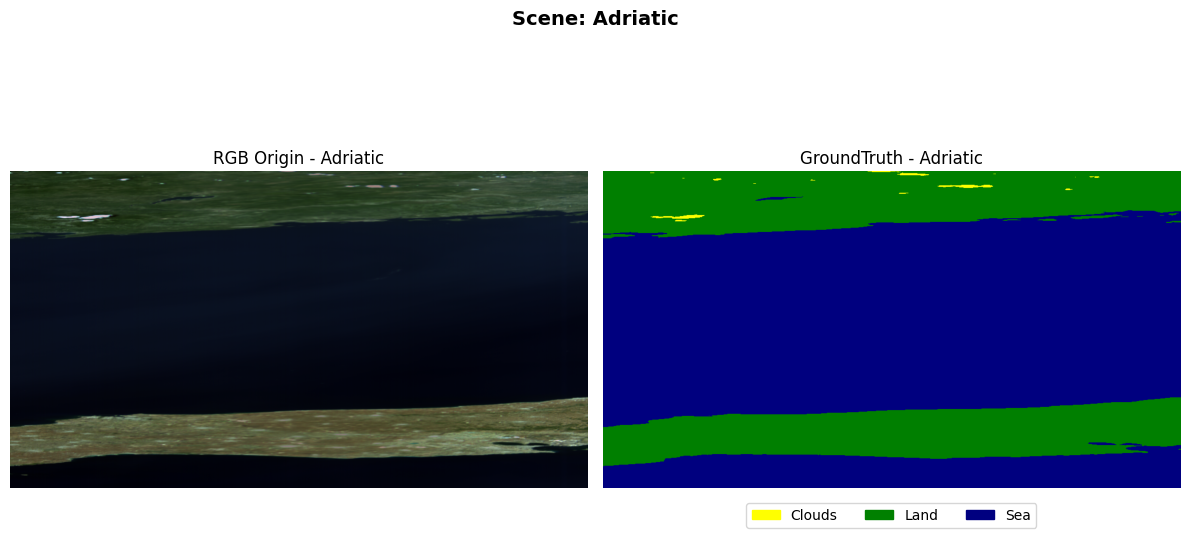

In [4]:
c1 = int(0)
#c1 = int(input("Select capture: "))
if data_file == 'l1a':
    hyperspectral_data = l1a_files[c1]
elif data_file == 'l1b':
    hyperspectral_data = l1b_files[c1]
elif data_file == 'l1d':
    hyperspectral_data = l1d_files[c1]
label = labels[c1]
scene_name = radiance_data_files[c1].split("_")[0]  



# class_names = { 1: "Snow", 2: "Land", 3: "Clouds", 4: "Sea"}  
# color_map = {
#     1: (1, 1, 1),        # Snow (white)
#     2: (0, 0.5, 0),      # Land (dark green)
#     3: (1, 1, 0),        # Clouds (yellow)
#     4: (0, 0, 0.5)       # Sea (dark blue)
# }

# Define class names and custom colormap
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert color map dictionary into a ListedColormap
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# Create subplots (only 2 now)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Generate RGB image using specified bands
rgb_data = spectral.get_rgb(hyperspectral_data, (69, 46, 26))  

# Plot the original RGB image
axes[0].imshow(rgb_data)
axes[0].set_title(f'RGB Origin - {scene_name.capitalize()}')
axes[0].axis('off')

# Plot the ground truth labels with the custom colormap
im = axes[1].imshow(label, cmap=custom_cmap)
axes[1].set_title(f'GroundTruth - {scene_name.capitalize()}')
axes[1].axis('off')

# Extract unique labels present in the current label image
unique_labels = np.unique(label)

# Create legend with corresponding colors
patches = [
    mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
    for label_val in unique_labels
]


axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

# Set the scene name in the title
plt.suptitle(f'Scene: {scene_name.capitalize()}', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

## Pre-process data

### Dimensionality Reduction (PCA)

In [5]:



# def batch_pca_processing(files, selected_bands, num_pca_components, batch_size=4):
 
#     pca_processed_images = []
#     total_batches = math.ceil(len(files) / batch_size)
    
#     with tqdm(total=len(files), desc="Processing PCA for images", unit="image") as pbar:
#         for batch_idx in range(total_batches):
#             start_idx = batch_idx * batch_size
#             end_idx = min((batch_idx + 1) * batch_size, len(files))
#             batch_files = files[start_idx:end_idx]
            
#             batch_results = []
#             for img in batch_files:
#                 # Extract only the selected bands
#                 filtered_data = img[:, :, selected_bands]
                
#                 # Flatten for PCA: Reshape to (pixels, bands)
#                 reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])
                
#                 # Apply PCA
#                 pca = PCA(n_components=num_pca_components)
#                 pca_data = pca.fit_transform(reshaped_data)
                
#                 # Reshape back to (H, W, PCA components)
#                 pca_data = pca_data.reshape(img.shape[0], img.shape[1], num_pca_components)
                
#                 batch_results.append(pca_data)
#                 pbar.update(1)
            
#             # Append batch results
#             pca_processed_images.extend(batch_results)
            
#             # Force garbage collection to free memory
#             gc.collect()
            
#     return np.array(pca_processed_images)

def batch_processing(files, selected_bands, num_pca_components=None, num_ica_components=None, batch_size=4, processing_type="pca"):
    """
    Applies PCA, ICA, or both on hyperspectral images in batches.
    
    Parameters:
        files (list): List of images (numpy arrays).
        selected_bands (list): Indices of spectral bands to process.
        num_pca_components (int, optional): Number of PCA components.
        num_ica_components (int, optional): Number of ICA components.
        batch_size (int): Number of images to process per batch.
        processing_type (str): "pca", "ica", "pca+ica", or "none".
        
    Returns:
        np.array: Processed images.
    """
    processed_images = []
    total_batches = math.ceil(len(files) / batch_size)
    
    with tqdm(total=len(files), desc=f"Processing {processing_type.upper()} for images", unit="image") as pbar:
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(files))
            batch_files = files[start_idx:end_idx]
            
            batch_results = []
            for img in batch_files:
                # Extract only the selected bands
                filtered_data = img[:, :, selected_bands]
                reshaped_data = filtered_data.reshape(-1, filtered_data.shape[-1])  # Flatten for PCA/ICA
                
                if processing_type == "pca":
                    pca = PCA(n_components=num_pca_components)
                    transformed_data = pca.fit_transform(reshaped_data)
                
                elif processing_type == "ica":
                    ica = FastICA(n_components=num_ica_components, random_state=42)
                    transformed_data = ica.fit_transform(reshaped_data)
                    
                elif processing_type == "pca+ica":
                    pca = PCA(n_components=num_pca_components)
                    pca_data = pca.fit_transform(reshaped_data)
                    
                    ica = FastICA(n_components=num_ica_components, random_state=42)
                    transformed_data = ica.fit_transform(pca_data)
                
                elif processing_type == "none":
                    transformed_data = reshaped_data  # No transformation
                
                # Reshape back to original (H, W, C) format
                num_components = transformed_data.shape[1]
                transformed_data = transformed_data.reshape(img.shape[0], img.shape[1], num_components)
                
                batch_results.append(transformed_data)
                pbar.update(1)
            
            processed_images.extend(batch_results)
            gc.collect()  # Free memory
            
    return np.array(processed_images)



## Patch Extraction

In [6]:
def apply_padding(image, patch_size, stride, mode='reflect'):
    height, width, channels = image.shape

    # Calculate padding needed
    pad_h = (patch_size - (height % stride)) % patch_size
    pad_w = (patch_size - (width % stride)) % patch_size

    # Apply padding to height and width
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode=mode)

    return padded_image

def extract_patches(image, patch_size=PATCH_SIZE, stride=STRIDE):
    if len(image.shape) == 2:  
        H, W = image.shape
        C = None
    else:  
        H, W, C = image.shape

    patches = []
    indices = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            if C is None: 
                patch = image[i:i+patch_size, j:j+patch_size]  
            else:  
                patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
            indices.append((i, j))

    return np.array(patches), indices



class PatchSet(Dataset):
    def __init__(self, images, labels=None, patch_size=PATCH_SIZE, stride=STRIDE, is_pred=False):
        self.images = images
        self.labels = labels
        self.patch_size = patch_size
        self.stride = stride
        self.is_pred = is_pred
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        self.image_to_patch_map = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            img_patches = []
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
        self.total_patches = len(self.patch_indices)
                    
    def __len__(self):
        return self.total_patches
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        if not self.is_pred and self.labels is not None:
            label = self.labels[img_idx]
            label_patch = label[i:i+patch_size, j:j+patch_size]
            label_tensor = torch.tensor(label_patch, dtype=torch.long)
            return patch_tensor, label_tensor
        
        return patch_tensor

    
class TestPatchSet(Dataset):
    def __init__(self, images, patch_size=PATCH_SIZE, stride=STRIDE):
        self.images = images
        self.patch_size = patch_size
        self.stride = stride
        
        # Pre-calculate patch indices for each image
        self.patch_indices = []
        
        for img_idx, img in enumerate(images):
            h, w = img.shape[:2]
            
            for i in range(0, h - patch_size + 1, stride):
                for j in range(0, w - patch_size + 1, stride):
                    self.patch_indices.append((img_idx, i, j))
                    
    def __len__(self):
        return len(self.patch_indices)
    
    def __getitem__(self, idx):
        img_idx, i, j = self.patch_indices[idx]
        img = self.images[img_idx]
        patch_size = self.patch_size
        
        # Extract the patch only when needed
        if len(img.shape) == 2:
            patch = img[i:i+patch_size, j:j+patch_size]
            # Add channel dimension if grayscale
            patch = np.expand_dims(patch, axis=0)
        else:
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Move channels to first dimension (C, H, W)
            patch = np.transpose(patch, (2, 0, 1))
            
        # Convert only this patch to tensor
        patch_tensor = torch.tensor(patch, dtype=torch.float32)
        
        return patch_tensor, img_idx
    
def reconstruct_image_with_confidence(patches, confidence_scores, original_shape, patch_size=PATCH_SIZE, stride=STRIDE):
    
    H, W = original_shape
    reconstructed = np.zeros((H, W), dtype=np.float32)
    weights = np.zeros((H, W), dtype=np.float32)

    patch_idx = 0
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            # Add weighted vote for each pixel
            patch_pred = patches[patch_idx]
            patch_conf = confidence_scores[patch_idx]
            
            reconstructed[i:i+patch_size, j:j+patch_size] += patch_pred * patch_conf
            weights[i:i+patch_size, j:j+patch_size] += patch_conf
            
            patch_idx += 1

    # Normalize by weights
    mask = weights > 0
    reconstructed[mask] = reconstructed[mask] / weights[mask]
    
    # Round to nearest integer for class labels
    return np.round(reconstructed).astype(np.uint8)



## Apply Transformations

In [ ]:

if data_file == 'l1a':
    files_to_process = l1a_files
elif data_file == 'l1b':
    files_to_process = l1b_files
elif data_file == 'l1d':
    files_to_process = l1d_files



# Selected spectral bands to use before PCA
selected_bands = [110, 109, 111, 108, 113, 112, 107, 102, 101, 100, 99, 106, 98, 103, 97, 96,
                            81, 80, 79, 78, 77, 76, 75, 74, 82, 85, 73, 86, 84, 95, 88, 87, 72, 89, 71,
                            70, 69, 90, 83, 68, 67, 93, 64, 66, 94, 65, 63, 62, 61, 60, 59, 9, 58, 91,
                            105, 57, 10, 54, 55, 56, 92, 53, 52, 51, 11, 12, 50, 49, 48, 47, 13, 46,
                            14, 6, 4, 45, 3, 5, 7, 34, 8, 15, 16, 25, 44, 33, 43, 35, 40, 36, 17, 41,
                            42, 37, 29, 39, 32, 38, 26, 20, 19, 18, 27, 28, 30, 24, 31, 21, 23, 22, 104]




PROCESSING_TYPE = "pca"  # Choose from "pca", "ica", "pca+ica", "none"

processed_images = batch_processing(
    files=files_to_process,
    selected_bands=selected_bands,
    num_pca_components=N_PCA,
    num_ica_components=N_ICA,
    batch_size=BATCH_SIZE,
    processing_type=PROCESSING_TYPE
)

print(processed_images.shape)

Processing PCA for images: 100%|██████████| 43/43 [01:59<00:00,  2.78s/image]


## Data Split

In [67]:

(training_files, testing_files, 
 training_labels, testing_labels, 
 training_filenames, testing_filenames, 
 training_label_filenames, testing_label_filenames) = train_test_split(
   processed_images, labels, l1d_filenames, label_filenames, 
    test_size=1 - TRAIN_SIZE, random_state=42
)



(train_images, val_images, 
 train_labels, val_labels, 
 train_filenames, val_filenames, 
 train_label_filenames, val_label_filenames) = train_test_split(
    training_files, training_labels, training_filenames, training_label_filenames,
    test_size=VALIDATION_SIZE, random_state=42
)
 
train_data = PatchSet(train_images, train_labels, PATCH_SIZE, STRIDE)  
val_data = PatchSet(val_images, val_labels, PATCH_SIZE, STRIDE)  
test_data = TestPatchSet(testing_files, TEST_PATCH_SIZE, TEST_STRIDE)  

# DataLoaders remain unchanged
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(f"✅ Training & validation DataLoaders ready. No memory overload!")



✅ Training & validation DataLoaders ready. No memory overload!


## Model

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_wavelets import DWTForward

class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        
        # Wavelet transform layers
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
        # Projection and convolution blocks
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()
        
        for i in range(levels):
            input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
            output_channels = 64 * (i + 1)

            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.3)  # Added Dropout for Regularization
            ))

        # Segmentation Head
        total_channels = sum(64 * (i + 1) for i in range(levels))
        self.seg_head = nn.Sequential(
            nn.Conv2d(total_channels, total_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(total_channels // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Conv2d(total_channels // 2, total_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # **Learnable Transposed Convolutions for Upsampling**
        self.upsample1 = nn.ConvTranspose2d(total_channels // 2, total_channels // 4, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(total_channels // 4, total_channels // 8, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(total_channels // 8, total_channels // 16, kernel_size=2, stride=2)
        self.upsample4 = nn.ConvTranspose2d(total_channels // 16, class_nums, kernel_size=2, stride=2)  # Final upsampling

    def forward(self, x):
        input_size = x.shape[2:]  # Store original input size
        features = []
        low_pass = x
        
        # Wavelet processing
        for i in range(self.levels):
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
            features.append(conv_out)

        # Process features for segmentation
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]
        
        out = torch.cat(resized_features, dim=1)
        out = self.seg_head(out)

        # **Progressive Learnable Upsampling**
        out = self.upsample1(out)  # Upsample from total_channels // 2 → total_channels // 4
        out = self.upsample2(out)  # Upsample from total_channels // 4 → total_channels // 8
        out = self.upsample3(out)  # Upsample from total_channels // 8 → total_channels // 16
        out = self.upsample4(out)  # Upsample from total_channels // 16 → final class_nums output

        return out


In [11]:
# class WaveletCNN(nn.Module):
#     def __init__(self, in_channels, class_nums, levels=4):
#         super(WaveletCNN, self).__init__()
#         self.levels = levels
        
#         # Wavelet transform layers
#         self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        
#         # Projection and convolution blocks with the same channel progression as the classification model
#         self.projections = nn.ModuleList()
#         self.conv_blocks = nn.ModuleList()
        
#         for i in range(levels):
#             # Keep the same channel calculation logic from the classification model
#             input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
#             output_channels = 64 * (i + 1)
            
#             self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
#             self.conv_blocks.append(nn.Sequential(
#                 nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(output_channels),
#                 nn.LeakyReLU(negative_slope=0.01, inplace=True),
#                 nn.Dropout(p=0.3)
#             ))
        
#         # Replace global pooling and FC layer with segmentation head
#         total_channels = sum(64 * (i + 1) for i in range(levels))
#         self.seg_head = nn.Sequential(
#             nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, groups=output_channels),
#             nn.Conv2d(output_channels, output_channels, kernel_size=1),
#             nn.BatchNorm2d(total_channels // 2),
#             nn.LeakyReLU(negative_slope=0.01, inplace=True),
#             nn.Dropout(p=0.3),
#             nn.Conv2d(total_channels // 2, class_nums, kernel_size=1)
#         )

#     def forward(self, x):
#         input_size = x.shape[2:]  # Store original input size
#         features = []
#         low_pass = x
        
#         # Wavelet processing (same as before)
#         for i in range(self.levels):
#             low_pass, high_pass = self.dwt[i](low_pass)
#             batch_size, channels, height, width = low_pass.shape
#             _, high_pass_channels, subbands, _, _ = high_pass[0].shape
#             high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)
            
#             resized_features = [
#                 F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
#                 for feat in features
#             ]
            
#             concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
#             projected = self.projections[i](concatenated)
#             conv_out = self.conv_blocks[i](projected)
#             features.append(conv_out)
        
#         # Process features for segmentation
#         smallest_height, smallest_width = features[-1].shape[2:]
#         resized_features = [
#             F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
#             for feat in features
#         ]
        
#         out = torch.cat(resized_features, dim=1)
#         out = self.seg_head(out)
        
#         # Upscale back to input size for segmentation
#         out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=False)
        
#         return out


In [69]:
num_components = N_PCA
# if PROCESSING_TYPE == "ica":
#      num_components = N_ICA
# elif PROCESSING_TYPE == "pca":
#      num_components = N_PCA
# else:
#      num_components = 120
                            

# Initialize the model
net = WaveletCNN(in_channels=num_components , class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, num_components,PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, num_components, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)



Input tensor shape: torch.Size([1, 30, 16, 16])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 30, 16, 16]    [1, 3, 16, 16]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 30, 16, 16]    [1, 30, 8, 8]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        7,744              [1, 1]             495,616            [1, 120, 8, 8]     [1, 64, 8, 8]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 64, 8, 8]     

## Training

Using device: cuda


100%|██████████| 2079/2079 [01:22<00:00, 25.12it/s]


Epoch 0/50 - Loss: 0.0000  Train Acc: 0.9042


Training::   2%|▏         | 1/50 [01:42<1:23:40, 102.45s/it]

Epoch 0/50 - Validation Acc: 0.8383
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_0_acc_0.8383.pth
✅ Epoch 1/50 completed in 102.45 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.29it/s]


Epoch 1/50 - Loss: 0.0000  Train Acc: 0.9386


Training::   4%|▍         | 2/50 [03:24<1:21:40, 102.10s/it]

Epoch 1/50 - Validation Acc: 0.8672
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_1_acc_0.8672.pth
✅ Epoch 2/50 completed in 101.86 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.22it/s]


Epoch 2/50 - Loss: 0.0000  Train Acc: 0.9449


Training::   6%|▌         | 3/50 [05:06<1:20:01, 102.15s/it]

Epoch 2/50 - Validation Acc: 0.8513
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_2_acc_0.8513.pth
✅ Epoch 3/50 completed in 102.22 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.17it/s]


Epoch 3/50 - Loss: 0.0000  Train Acc: 0.9474


Training::   8%|▊         | 4/50 [06:48<1:18:24, 102.26s/it]

Epoch 3/50 - Validation Acc: 0.8544
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_3_acc_0.8544.pth
✅ Epoch 4/50 completed in 102.43 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.10it/s]


Epoch 4/50 - Loss: 0.0000  Train Acc: 0.9493


Training::  10%|█         | 5/50 [08:31<1:16:47, 102.39s/it]

Epoch 4/50 - Validation Acc: 0.8503
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_4_acc_0.8503.pth
✅ Epoch 5/50 completed in 102.60 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.47it/s]


Epoch 5/50 - Loss: 0.0000  Train Acc: 0.9501


Training::  12%|█▏        | 6/50 [10:12<1:14:47, 101.98s/it]

Epoch 5/50 - Validation Acc: 0.8723
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_5_acc_0.8723.pth
✅ Epoch 6/50 completed in 101.19 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.46it/s]


Epoch 6/50 - Loss: 0.0000  Train Acc: 0.9510


Training::  14%|█▍        | 7/50 [11:53<1:12:54, 101.73s/it]

Epoch 6/50 - Validation Acc: 0.8433
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_6_acc_0.8433.pth
✅ Epoch 7/50 completed in 101.22 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.15it/s]


Epoch 7/50 - Loss: 0.0000  Train Acc: 0.9512


Training::  16%|█▌        | 8/50 [13:36<1:11:21, 101.95s/it]

Epoch 7/50 - Validation Acc: 0.8460
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_7_acc_0.8460.pth
✅ Epoch 8/50 completed in 102.41 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.30it/s]


Epoch 8/50 - Loss: 0.0000  Train Acc: 0.9518


Training::  18%|█▊        | 9/50 [15:18<1:09:40, 101.96s/it]

Epoch 8/50 - Validation Acc: 0.8471
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_8_acc_0.8471.pth
✅ Epoch 9/50 completed in 102.00 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.27it/s]


Epoch 9/50 - Loss: 0.0000  Train Acc: 0.9520


Training::  20%|██        | 10/50 [17:00<1:08:00, 102.01s/it]

Epoch 9/50 - Validation Acc: 0.8747
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_9_acc_0.8747.pth
✅ Epoch 10/50 completed in 102.11 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.23it/s]


Epoch 10/50 - Loss: 0.0000  Train Acc: 0.9523


Training::  22%|██▏       | 11/50 [18:42<1:06:20, 102.06s/it]

Epoch 10/50 - Validation Acc: 0.8634
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_10_acc_0.8634.pth
✅ Epoch 11/50 completed in 102.17 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.24it/s]


Epoch 11/50 - Loss: 0.0000  Train Acc: 0.9528


Training::  24%|██▍       | 12/50 [20:24<1:04:39, 102.09s/it]

Epoch 11/50 - Validation Acc: 0.8443
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_11_acc_0.8443.pth
✅ Epoch 12/50 completed in 102.15 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.22it/s]


Epoch 12/50 - Loss: 0.0000  Train Acc: 0.9528


Training::  26%|██▌       | 13/50 [22:07<1:02:59, 102.14s/it]

Epoch 12/50 - Validation Acc: 0.8525
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_12_acc_0.8525.pth
✅ Epoch 13/50 completed in 102.27 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.27it/s]


Epoch 13/50 - Loss: 0.0000  Train Acc: 0.9532


Training::  28%|██▊       | 14/50 [23:49<1:01:16, 102.13s/it]

Epoch 13/50 - Validation Acc: 0.8787
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_13_acc_0.8787.pth
✅ Epoch 14/50 completed in 102.09 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.27it/s]


Epoch 14/50 - Loss: 0.0000  Train Acc: 0.9528


Training::  30%|███       | 15/50 [25:31<59:33, 102.11s/it]  

Epoch 14/50 - Validation Acc: 0.7910
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_14_acc_0.7910.pth
✅ Epoch 15/50 completed in 102.07 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.24it/s]


Epoch 15/50 - Loss: 0.0000  Train Acc: 0.9532


Training::  32%|███▏      | 16/50 [27:13<57:52, 102.12s/it]

Epoch 15/50 - Validation Acc: 0.8754
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_15_acc_0.8754.pth
✅ Epoch 16/50 completed in 102.15 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.26it/s]


Epoch 16/50 - Loss: 0.0000  Train Acc: 0.9528


Training::  34%|███▍      | 17/50 [28:55<56:09, 102.11s/it]

Epoch 16/50 - Validation Acc: 0.8617
📉 Current learning rate: 0.001
💾 Model saved: results\l1d\epoch_16_acc_0.8617.pth
✅ Epoch 17/50 completed in 102.08 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.25it/s]


Epoch 17/50 - Loss: 0.0000  Train Acc: 0.9531


Training::  36%|███▌      | 18/50 [30:37<54:25, 102.05s/it]

Epoch 17/50 - Validation Acc: 0.8127
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_17_acc_0.8127.pth
✅ Epoch 18/50 completed in 101.91 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.18it/s]


Epoch 18/50 - Loss: 0.0000  Train Acc: 0.9579


Training::  38%|███▊      | 19/50 [32:19<52:44, 102.08s/it]

Epoch 18/50 - Validation Acc: 0.8623
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_18_acc_0.8623.pth
✅ Epoch 19/50 completed in 102.14 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.17it/s]


Epoch 19/50 - Loss: 0.0000  Train Acc: 0.9575


Training::  40%|████      | 20/50 [34:01<51:05, 102.17s/it]

Epoch 19/50 - Validation Acc: 0.8628
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_19_acc_0.8628.pth
✅ Epoch 20/50 completed in 102.40 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.22it/s]


Epoch 20/50 - Loss: 0.0000  Train Acc: 0.9579


Training::  42%|████▏     | 21/50 [35:44<49:23, 102.19s/it]

Epoch 20/50 - Validation Acc: 0.8478
📉 Current learning rate: 0.0005
💾 Model saved: results\l1d\epoch_20_acc_0.8478.pth
✅ Epoch 21/50 completed in 102.23 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.27it/s]


Epoch 21/50 - Loss: 0.0000  Train Acc: 0.9578


Training::  44%|████▍     | 22/50 [37:26<47:40, 102.15s/it]

Epoch 21/50 - Validation Acc: 0.8649
📉 Current learning rate: 0.00025
💾 Model saved: results\l1d\epoch_21_acc_0.8649.pth
✅ Epoch 22/50 completed in 102.07 seconds.


100%|██████████| 2079/2079 [01:22<00:00, 25.27it/s]


Epoch 22/50 - Loss: 0.0000  Train Acc: 0.9608


Training::  46%|████▌     | 23/50 [39:07<45:55, 102.04s/it]

Epoch 22/50 - Validation Acc: 0.8624
📉 Current learning rate: 0.00025
💾 Model saved: results\l1d\epoch_22_acc_0.8624.pth
✅ Epoch 23/50 completed in 101.77 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.63it/s]


Epoch 23/50 - Loss: 0.0000  Train Acc: 0.9607


Training::  48%|████▊     | 24/50 [40:48<44:04, 101.70s/it]

Epoch 23/50 - Validation Acc: 0.8690
📉 Current learning rate: 0.00025
💾 Model saved: results\l1d\epoch_23_acc_0.8690.pth
✅ Epoch 24/50 completed in 100.90 seconds.


100%|██████████| 2079/2079 [01:20<00:00, 25.68it/s]


Epoch 24/50 - Loss: 0.0000  Train Acc: 0.9614


Training::  50%|█████     | 25/50 [42:29<42:13, 101.34s/it]

Epoch 24/50 - Validation Acc: 0.8644
📉 Current learning rate: 0.00025
💾 Model saved: results\l1d\epoch_24_acc_0.8644.pth
✅ Epoch 25/50 completed in 100.52 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.52it/s]


Epoch 25/50 - Loss: 0.0000  Train Acc: 0.9613


Training::  52%|█████▏    | 26/50 [44:10<40:31, 101.30s/it]

Epoch 25/50 - Validation Acc: 0.8645
📉 Current learning rate: 0.000125
💾 Model saved: results\l1d\epoch_25_acc_0.8645.pth
✅ Epoch 26/50 completed in 101.20 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.48it/s]


Epoch 26/50 - Loss: 0.0000  Train Acc: 0.9629


Training::  54%|█████▍    | 27/50 [45:51<38:47, 101.21s/it]

Epoch 26/50 - Validation Acc: 0.8701
📉 Current learning rate: 0.000125
💾 Model saved: results\l1d\epoch_26_acc_0.8701.pth
✅ Epoch 27/50 completed in 101.00 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.54it/s]


Epoch 27/50 - Loss: 0.0000  Train Acc: 0.9632


Training::  56%|█████▌    | 28/50 [47:32<37:05, 101.18s/it]

Epoch 27/50 - Validation Acc: 0.8691
📉 Current learning rate: 0.000125
💾 Model saved: results\l1d\epoch_27_acc_0.8691.pth
✅ Epoch 28/50 completed in 101.11 seconds.


100%|██████████| 2079/2079 [01:21<00:00, 25.55it/s]


Epoch 28/50 - Loss: 0.0000  Train Acc: 0.9633


Training::  56%|█████▌    | 28/50 [49:13<38:40, 105.48s/it]


Epoch 28/50 - Validation Acc: 0.8567
📉 Current learning rate: 0.000125
💾 Model saved: results\l1d\epoch_28_acc_0.8567.pth
⏹️ Early stopping triggered at epoch 28. Best val_acc: 0.8787
🏁 Training completed in 2953.55 seconds.
🛑 Stopped at epoch 28
best model:epoch_13_acc_0.8787.pth


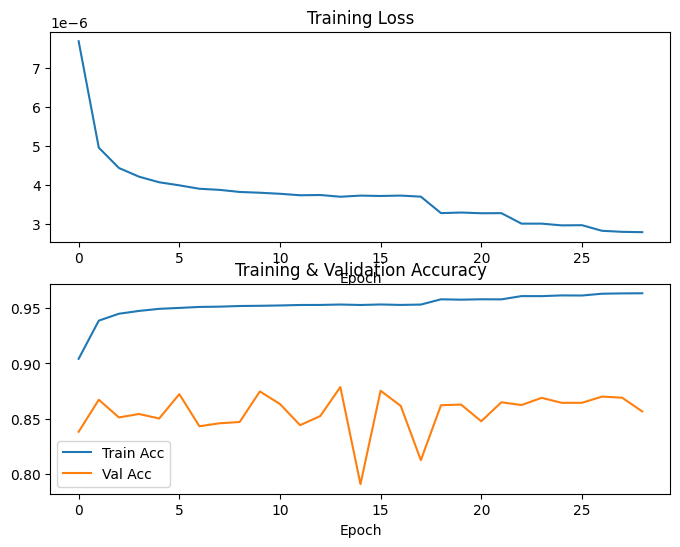

🎯 Best model retained: results\l1d\epoch_13_acc_0.8787.pth


In [70]:
import torch
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(DEVICE)
print(f"Using device: {device}")

# Model, optimizer, loss function
model = WaveletCNN(num_components, class_nums=NUM_CLASS).to(device)
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
loss_func = torch.nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Tracking variables
loss_list, acc_list, val_acc_list, val_epoch_list = [], [], [], []
best_val_acc = 0.0
patience = 15  # Early stopping patience
early_stop_counter = 0
epoch_stop_threshold = 0.05  # Prevent stopping too early

train_num = len(train_loader.dataset) * PATCH_SIZE * PATCH_SIZE
val_num = len(val_loader.dataset) * PATCH_SIZE * PATCH_SIZE

start_time = time.time()

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.0
        train_acc = 0
        prev_batch_loss = None  # Store previous batch loss

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  # Shift class labels
            loss = loss_func(out, target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _, pred = torch.max(out, dim=1)
            train_acc += (pred == target).sum().item()

            # # **Mid-Epoch Stopping Check (Only if at least 20% of the epoch is completed)**
            # if prev_batch_loss is not None and batch_idx > len(train_loader) // 5:
            #     loss_change = abs(loss.item() - prev_batch_loss) / (prev_batch_loss + 1e-8)
            #     if loss_change < epoch_stop_threshold:
            #         print(f"🛑 Stopping epoch {e} early due to minimal loss improvement at batch {batch_idx}")
            #         break  # Exit batch loop (stop epoch early)
            # prev_batch_loss = loss.item()

        # Store training loss and accuracy
        loss_list.append(avg_loss / train_num)
        acc_list.append(train_acc / train_num)
        print(f"Epoch {e}/{EPOCH} - Loss: {loss_list[-1]:.4f}  Train Acc: {acc_list[-1]:.4f}")

        ## Validation step
        model.eval()
        val_acc = 0
        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(val_loader), total=len(val_loader)):
                data, target = data.to(device), target.to(device)
                out = model(data)
                target = target - 1  # Shift class labels
                _, pred = torch.max(out, dim=1)
                val_acc += (pred == target).sum().item()

        val_acc /= val_num
        val_acc_list.append(val_acc)
        val_epoch_list.append(e)
        print(f"Epoch {e}/{EPOCH} - Validation Acc: {val_acc:.4f}")

        # Adjust learning rate based on validation accuracy
        scheduler.step(val_acc_list[-1])

        # Print current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"📉 Current learning rate: {current_lr}")

        # Save the model (with epoch & accuracy in filename)
        save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc:.4f}.pth")
        torch.save(model.state_dict(), save_name)
        print(f"💾 Model saved: {save_name}")

        # Update best model tracking
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0  # Reset patience counter
        else:
            early_stop_counter += 1  # Increment counter

        # Check early stopping condition for entire training
        if early_stop_counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {e}. Best val_acc: {best_val_acc:.4f}")
            break  # Exit training loop
        
        epoch_end_time = time.time()
        print(f"✅ Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")

except Exception as exc:
    print(f"⚠️ Training interrupted: {exc}")
finally:
    total_time = time.time() - start_time
    print(f"🏁 Training completed in {total_time:.2f} seconds.")
    print(f"🛑 Stopped at epoch {e}")

    # Get best model and remove others
    best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)

    # Plot training loss and accuracy
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    ax1.plot(np.arange(len(loss_list)), loss_list, label="Training Loss")
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Epoch")

    ax2.plot(np.arange(len(acc_list)), acc_list, label="Train Acc")
    ax2.plot(val_epoch_list, val_acc_list, label="Val Acc")
    ax2.set_title("Training & Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()
    plt.show()

print(f"🎯 Best model retained: {best_model_path}")


### Save Best Model

In [71]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

best model:epoch_13_acc_0.8787.pth
✅ Loading Best Model from: results\l1d\epoch_13_acc_0.8787.pth
✅ Model loaded successfully. Ready for inference!

Processing Test Image 1/9 - Scene: solbergstrand_2024-07-08T09-39-39Z
Unique classes in ground truth before plotting: [1 2 3]


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_15420\3862064805.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_mode

Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


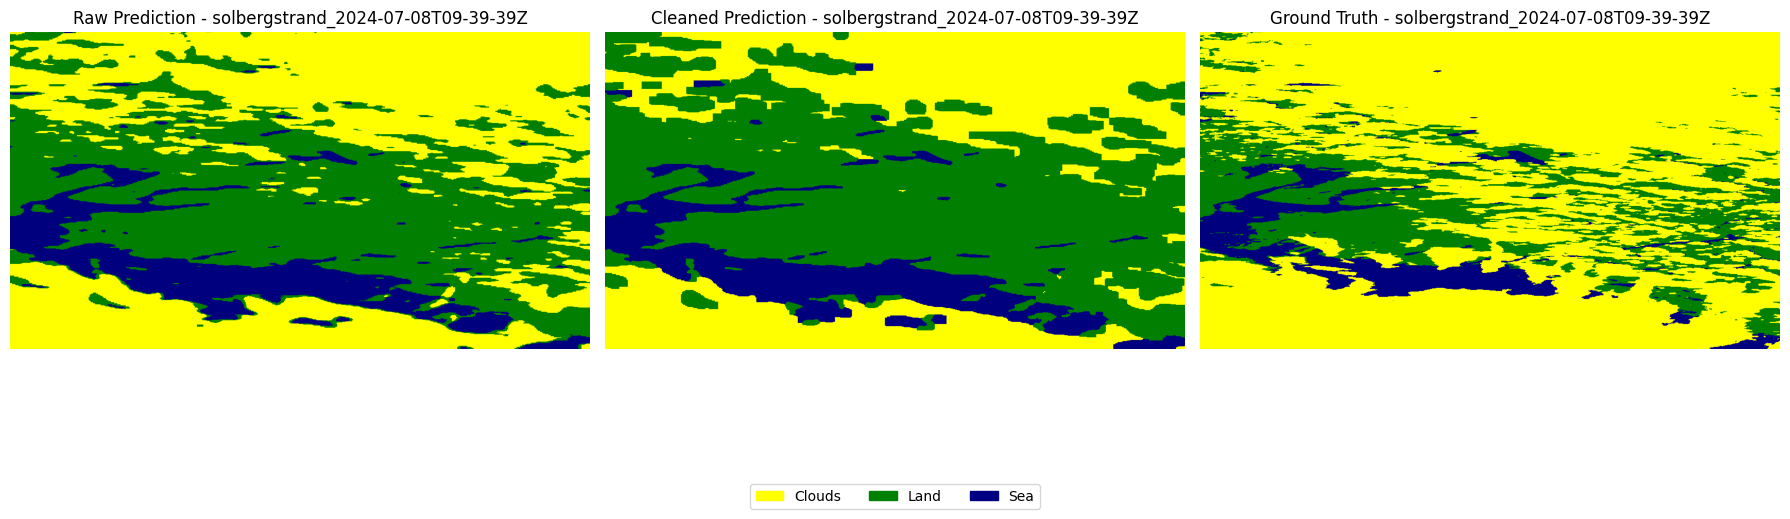


Processing Test Image 2/9 - Scene: lagunaDeTerminos_2024-12-06T16-07-50Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 2: 100%|██████████| 1230/1230 [00:43<00:00, 28.46it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [1 2]


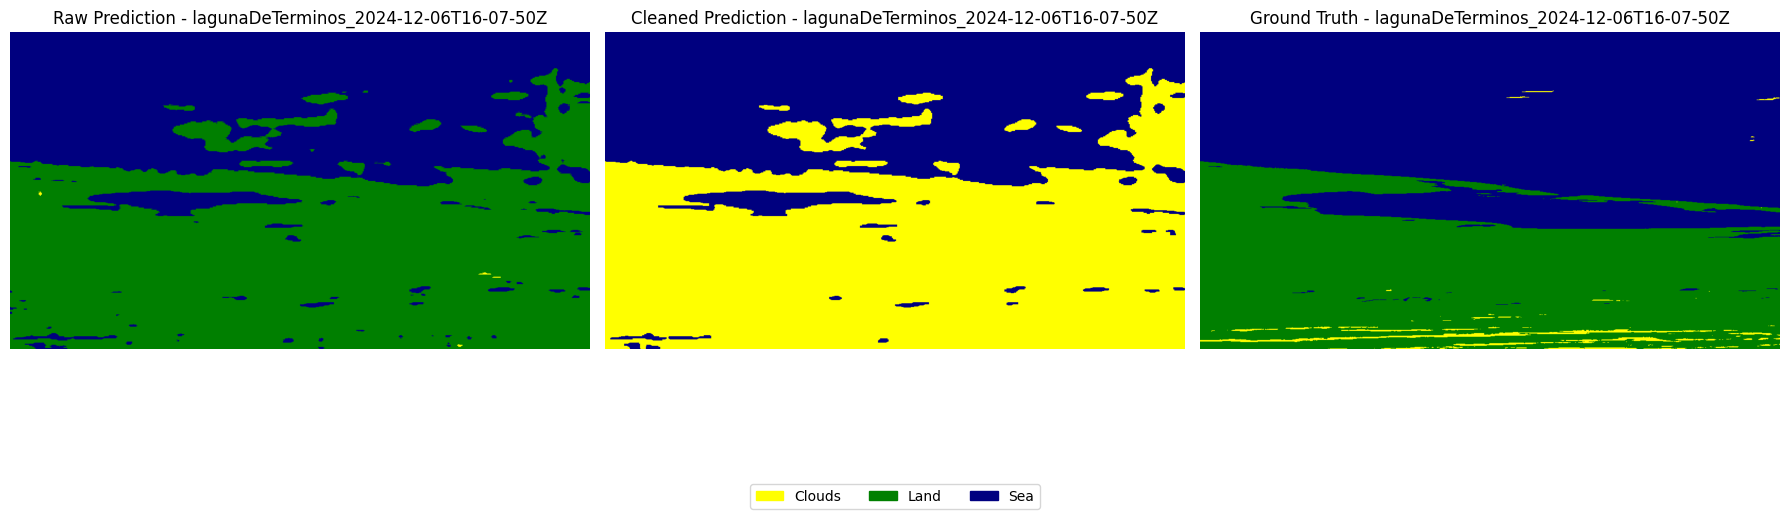


Processing Test Image 3/9 - Scene: lakewinnipeg_2024-08-13T17-07-06Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 3: 100%|██████████| 1230/1230 [00:43<00:00, 28.46it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


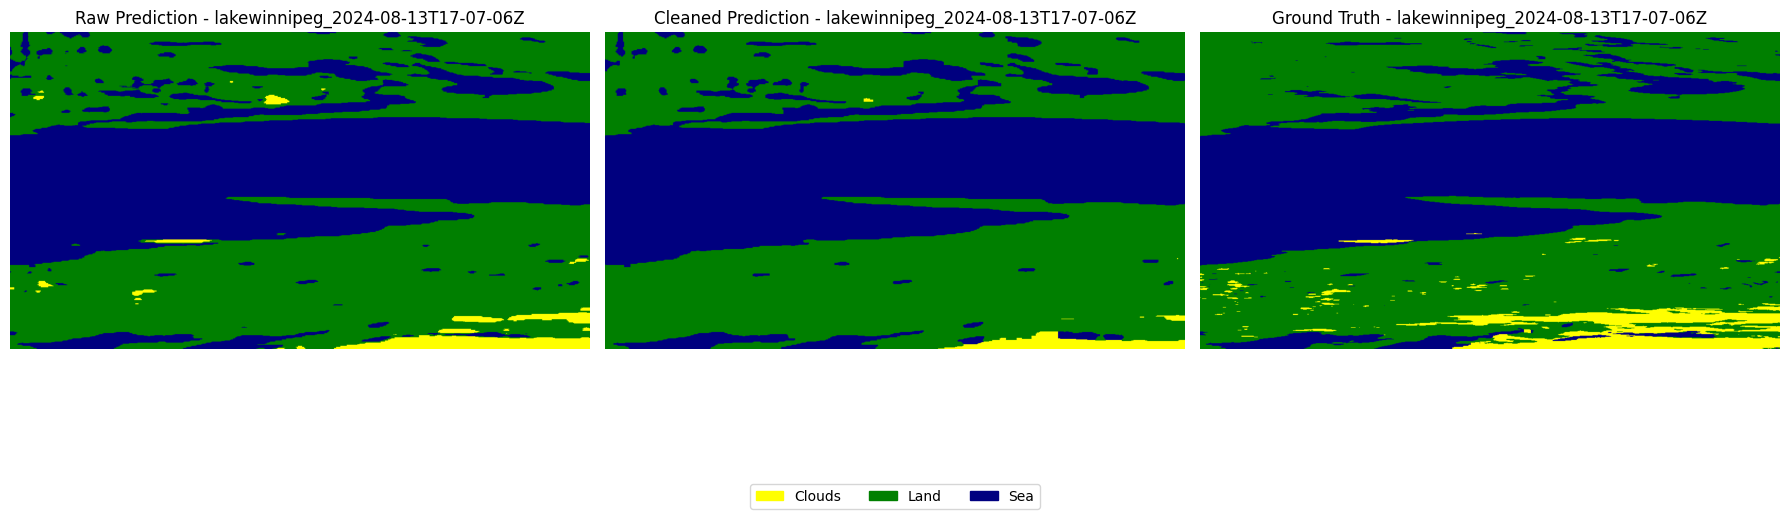


Processing Test Image 4/9 - Scene: sicilychannel_2024-12-28T09-23-44Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 4: 100%|██████████| 1230/1230 [00:43<00:00, 28.41it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


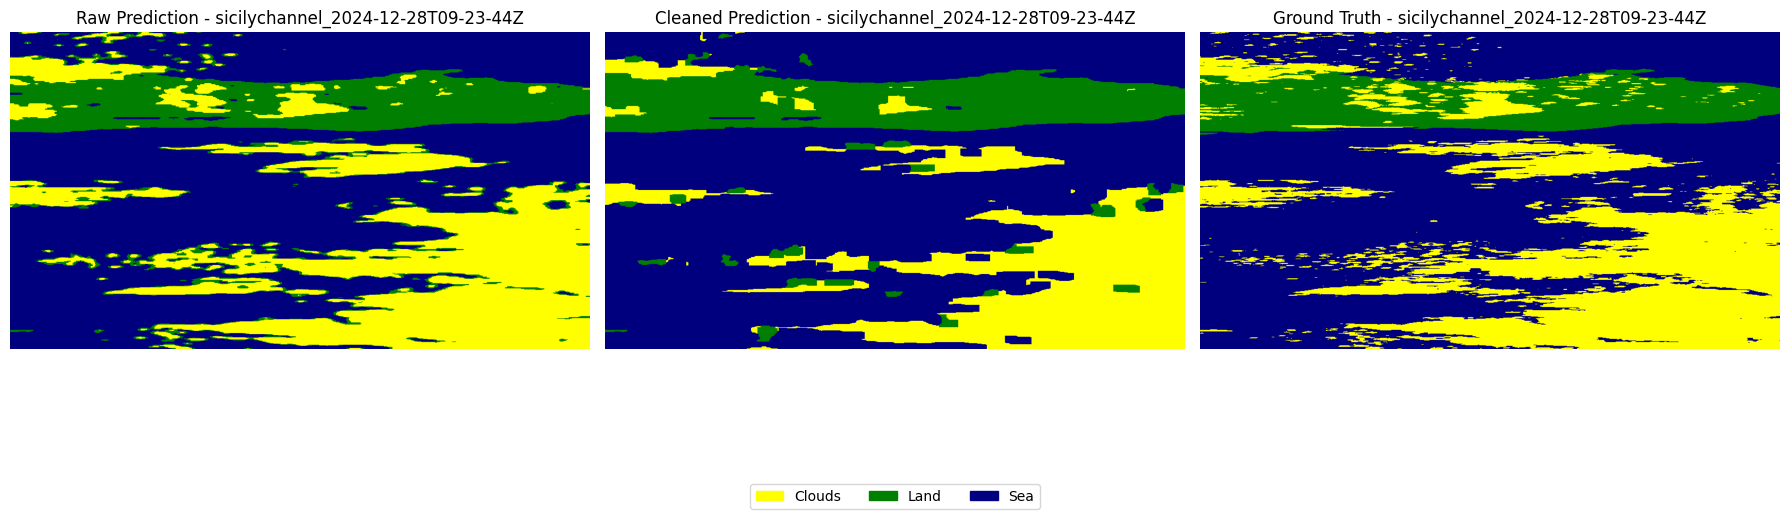


Processing Test Image 5/9 - Scene: rogaland_2024-06-01T09-56-49Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 5: 100%|██████████| 1230/1230 [00:43<00:00, 28.47it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


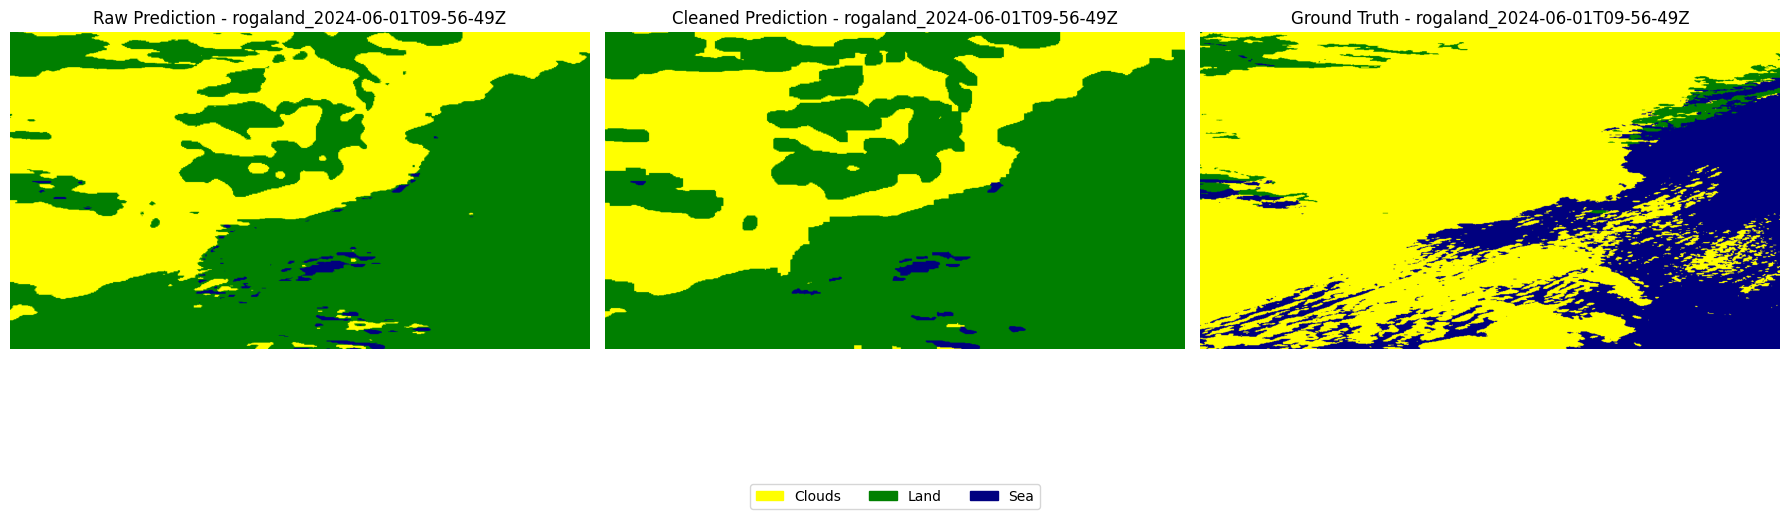


Processing Test Image 6/9 - Scene: tenerife_2025-01-17T11-17-36Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 6: 100%|██████████| 1230/1230 [00:43<00:00, 28.16it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


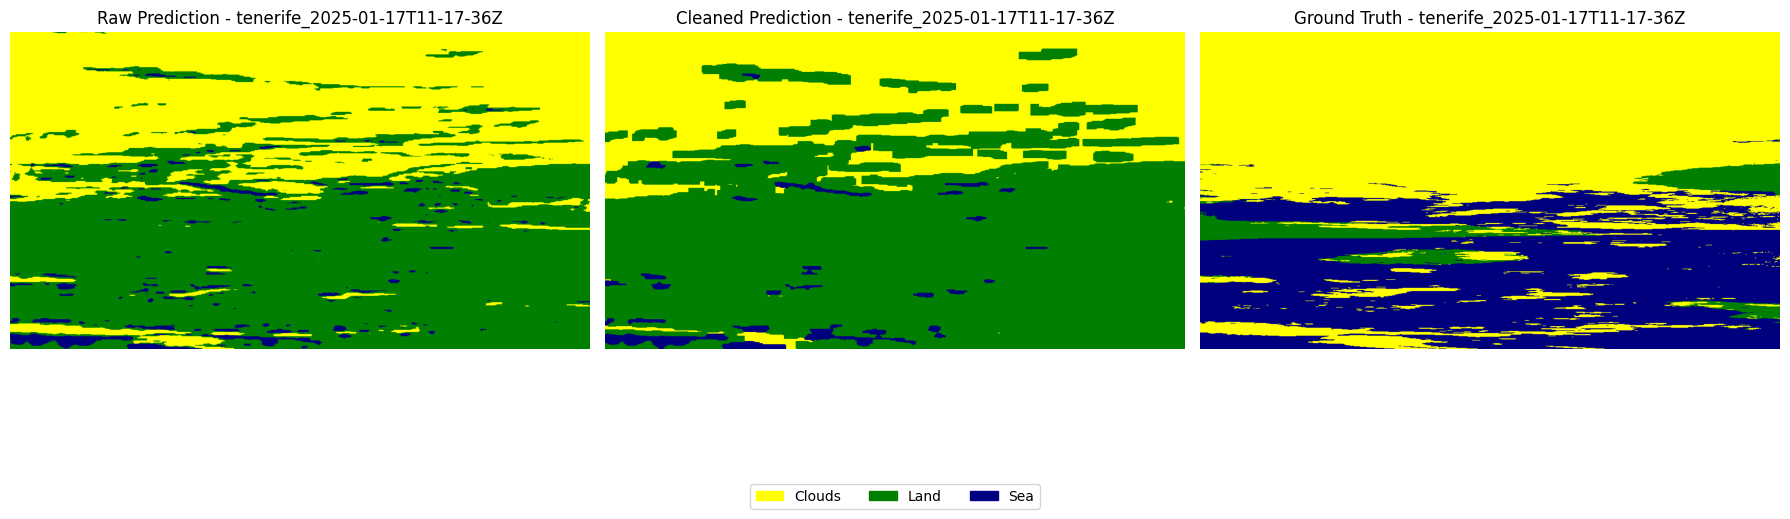


Processing Test Image 7/9 - Scene: aquawatchplymouth_2025-03-04T10-37-14Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 7: 100%|██████████| 1230/1230 [00:42<00:00, 29.24it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


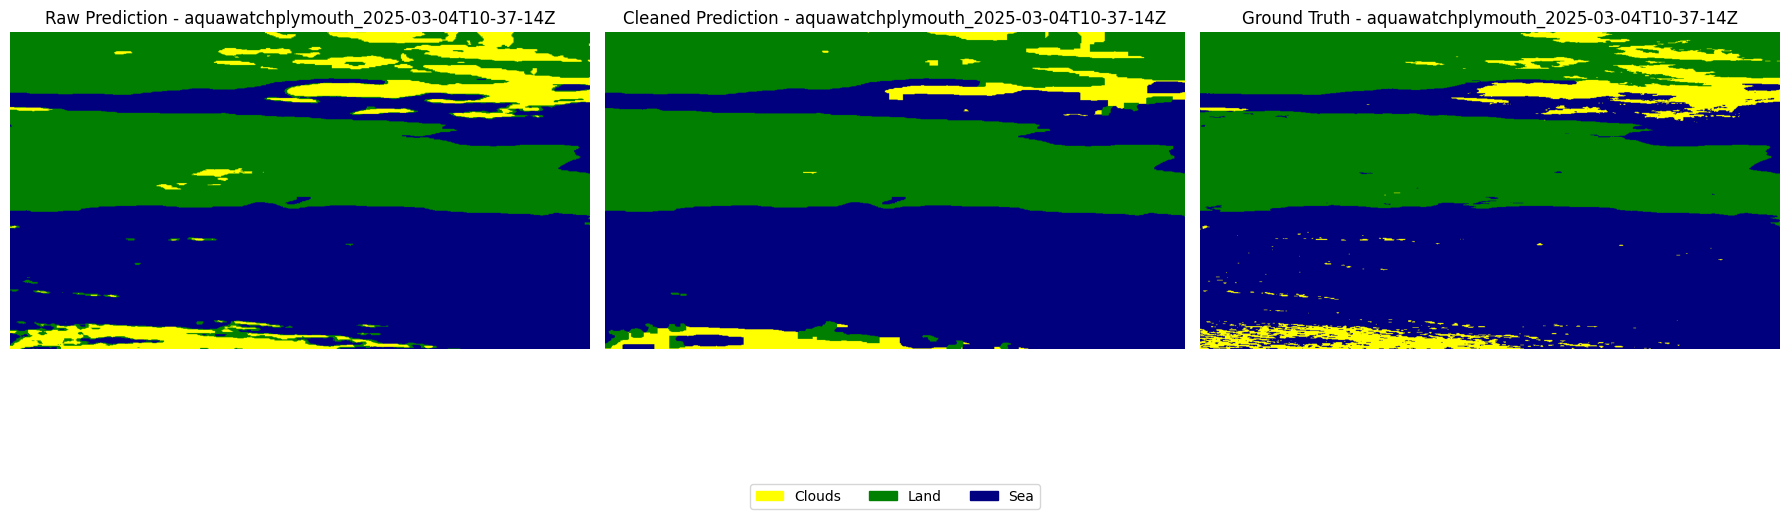


Processing Test Image 8/9 - Scene: flindersIsland_2024-11-09T23-33-38Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 8: 100%|██████████| 1230/1230 [00:42<00:00, 28.68it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


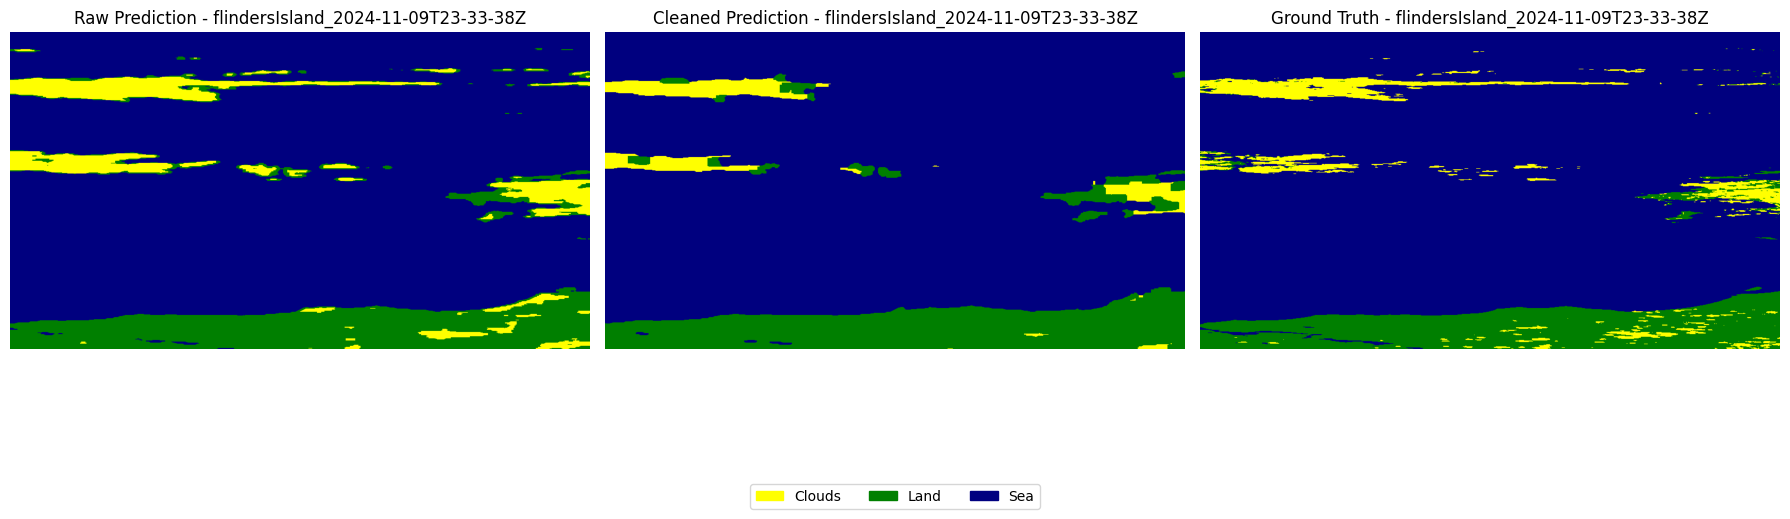


Processing Test Image 9/9 - Scene: dubai_2024-11-21T06-24-16Z
Unique classes in ground truth before plotting: [1 2 3]


Predicting Image 9: 100%|██████████| 1230/1230 [00:42<00:00, 29.26it/s]


Unique classes in prediction before post-processing: [0 1 2]
Unique classes in prediction after post-processing: [0 1 2]


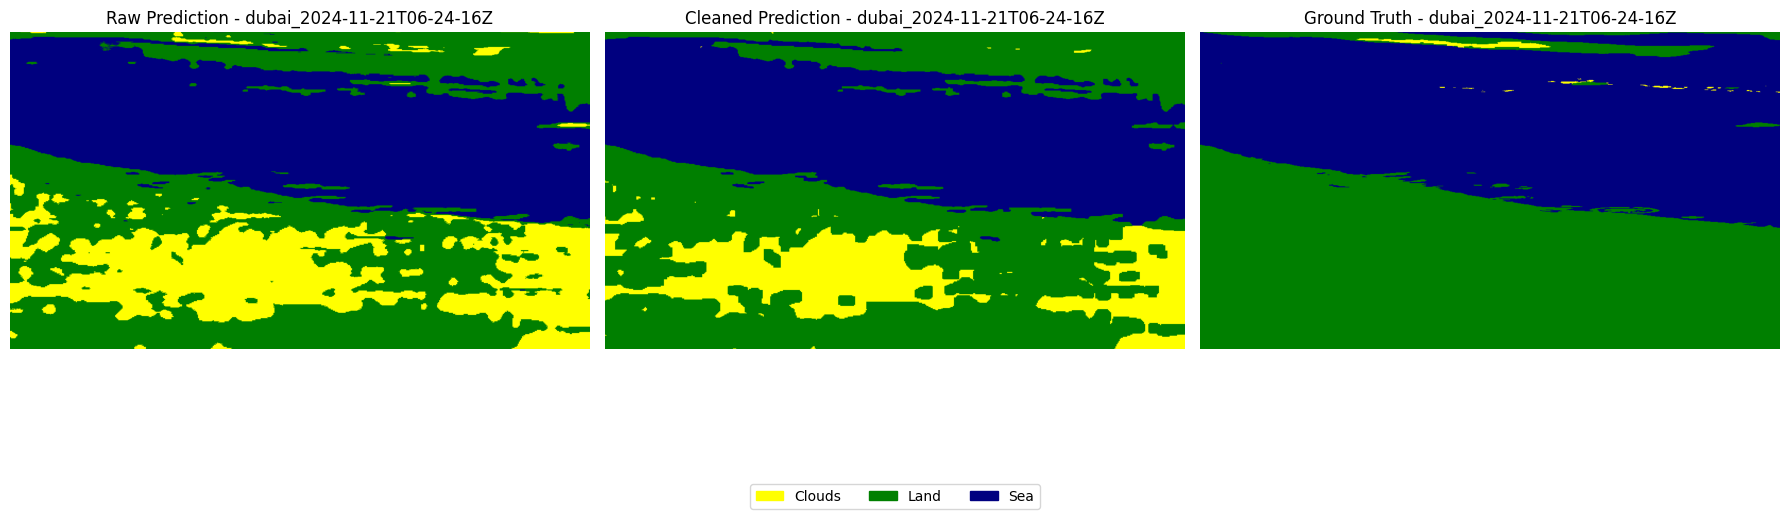

In [72]:



# Define class names and color map (same as original ground truth)
class_names = {1: "Clouds", 2: "Land", 3: "Sea"}
color_map = {
    1: (1, 1, 0),   # Clouds (yellow)
    2: (0, 0.5, 0), # Land (dark green)
    3: (0, 0, 0.5)  # Sea (dark blue)
}

# Convert dictionary to a ListedColormap for Matplotlib
custom_cmap = mcolors.ListedColormap([color_map[i] for i in sorted(color_map.keys())])

# ✅ Pre-load the correct ground truth labels for the test files
testing_label_dict = {
    os.path.basename(fname).replace("-l1a_labels.dat", ""): label
    for fname, label in zip(label_filenames, labels)
}

## Load the best trained model
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
print(f"✅ Loading Best Model from: {best_model_path}")

best_model = WaveletCNN(num_components, class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))  # Ensure correct device

## Move model to GPU if available
best_model.to(device)
best_model.eval()  # Set model to evaluation mode

print("✅ Model loaded successfully. Ready for inference!")

def post_process_segmentation(segmentation, min_size=100):
    """
    Apply post-processing to remove small isolated regions
    and smooth boundaries
    
    Args:
        segmentation: Predicted segmentation map
        min_size: Minimum region size to keep
    """
    # Get unique labels
    labels = np.unique(segmentation)
    
    # Create cleaned segmentation
    cleaned = np.zeros_like(segmentation)
    
    for label in labels:
        if label == 0:  # Skip background if present
            continue
            
        # Create binary mask for this class
        mask = (segmentation == label)
        
        # Remove small objects
        cleaned_mask = ndimage.binary_opening(mask, structure=np.ones((3,3)))
        
        # Remove small holes
        cleaned_mask = ndimage.binary_closing(cleaned_mask, structure=np.ones((3,3)))
        
        # Label connected components
        labeled, num = ndimage.label(cleaned_mask)
        
        # Remove small components
        for i in range(1, num+1):
            component = (labeled == i)
            if np.sum(component) < min_size:
                cleaned_mask[component] = 0
                
        # Add to result
        cleaned[cleaned_mask] = label
        
    # Fill any remaining unlabeled pixels with most common neighbor
    unlabeled = (cleaned == 0)
    if np.any(unlabeled):
        # Dilate existing labels into unlabeled regions
        temp = cleaned.copy()
        for _ in range(5):  # Repeat a few times to fill larger gaps
            if not np.any(unlabeled):
                break
            for label in labels:
                if label == 0:
                    continue
                mask = (temp == label)
                dilated = ndimage.binary_dilation(mask, structure=np.ones((3,3)))
                # Only fill unlabeled regions
                cleaned[(dilated) & (unlabeled)] = label
                # Update unlabeled mask
                unlabeled = (cleaned == 0)
                temp = cleaned.copy()
    
    return cleaned


for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1d.nc', '')  
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")


    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue 

 
    print(f"Unique classes in ground truth before plotting: {np.unique(ground_truth)}")

    test_img = testing_files[img_idx]

  
    test_data = TestPatchSet([test_img], patch_size=16, stride=2)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    pred_patches = []
    confidence_scores = []

    for batch_idx, (data, image_indices) in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Predicting Image {img_idx + 1}"):
        data = data.to(device)  

       
        out = best_model(data)
        probs = F.softmax(out, dim=1) 
    
        max_probs, pred = torch.max(probs, dim=1)
        
    
        pred_patches.append(pred.detach().cpu().numpy())
        confidence_scores.append(max_probs.detach().cpu().numpy())


    pred_patches = np.concatenate(pred_patches, axis=0)
    confidence_scores = np.concatenate(confidence_scores, axis=0)

   
    original_shape = test_img.shape[:2]  # Extract (H, W) only
    
  
    pred_map = reconstruct_image_with_confidence(
        pred_patches, 
        confidence_scores, 
        original_shape, 
        patch_size=16, 
        stride=2
    )
    

    pred_map_cleaned = post_process_segmentation(pred_map, min_size=100)
    

    print(f"Unique classes in prediction before post-processing: {np.unique(pred_map)}")
    print(f"Unique classes in prediction after post-processing: {np.unique(pred_map_cleaned)}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(pred_map, cmap=custom_cmap)
    axes[0].set_title(f'Raw Prediction - {scene_name}')
    axes[0].axis("off")  

   
    axes[1].imshow(pred_map_cleaned, cmap=custom_cmap)
    axes[1].set_title(f'Cleaned Prediction - {scene_name}')
    axes[1].axis("off")

   
    axes[2].imshow(ground_truth, cmap=custom_cmap)
    axes[2].set_title(f'Ground Truth - {scene_name}')
    axes[2].axis("off")

    
    unique_labels = np.unique(ground_truth)
    patches = [
        mpatches.Patch(color=color_map[label_val], label=class_names.get(label_val, f"Class {label_val}"))
        for label_val in unique_labels
    ]
    fig.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=3, fontsize=10)


    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()


## Evaluation

In [ ]:
all_true_labels = []
all_pred_labels = []
eval_results = []

for img_idx, test_img_filename in enumerate(testing_filenames):  
    scene_name = os.path.basename(test_img_filename).replace('-l1b.nc', '')  # Extract scene name
    print(f"\nProcessing Test Image {img_idx + 1}/{len(testing_filenames)} - Scene: {scene_name}")

    # ✅ Load the correct ground truth label file
    if scene_name in testing_label_dict:
        ground_truth = testing_label_dict[scene_name]  # Load the correct label
    else:
        print(f"❌ Warning: No matching ground truth found for {scene_name}")
        continue  # Skip this test case if there's no matching label

    ## ✅ Extract valid pixels (ignore background pixels where ground truth is 0)
    test_pred = pred_map[ground_truth != 0]
    test_true = ground_truth[ground_truth != 0]

    ## ✅ Compute metrics for this individual image
    OA = accuracy_score(test_true, test_pred)
    AA = recall_score(test_true, test_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(test_true, test_pred)

    unique_classes = np.unique(test_true)

    # ✅ Ensure only present classes are used in target_names
    target_names = [class_names[c] for c in unique_classes if c in class_names]

    # ✅ Compute classification report with dynamically detected classes
    class_report = classification_report(test_true, test_pred, labels=unique_classes, target_names=target_names, digits=4, zero_division=0)


    # ✅ Store the individual results
    eval_results.append({
        "Scene": scene_name,
        "Overall Accuracy": round(OA, 4),
        "Average Accuracy": round(AA, 4),
        "Kappa Score": round(kappa, 4),
        "Classification Report": class_report
    })

    ## ✅ Append results for total evaluation
    all_true_labels.extend(test_true)
    all_pred_labels.extend(test_pred)

    ## ✅ Print individual report
    print(f"\n📌 Evaluation for {scene_name}:")
    print(f"OA: {OA:.4f} | AA: {AA:.4f} | Kappa: {kappa:.4f}")
    print(class_report)
    print("-" * 80)



## ✅ Convert lists to NumPy arrays
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

## ✅ Compute overall metrics
OA_total = accuracy_score(all_true_labels, all_pred_labels)
AA_total = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
kappa_total = cohen_kappa_score(all_true_labels, all_pred_labels)
# ✅ Dynamically get unique class values
unique_classes_overall = np.unique(all_true_labels)

# ✅ Ensure only present classes are used in target_names
target_names_overall = [class_names[c] for c in unique_classes_overall if c in class_names]

# ✅ Compute classification report with dynamically detected classes
overall_class_report = classification_report(all_true_labels, all_pred_labels, labels=unique_classes_overall, target_names=target_names_overall, digits=4, zero_division=0)

## ✅ Store final evaluation
eval_results.append({
    "Scene": "Overall",
    "Overall Accuracy": round(OA_total, 4),
    "Average Accuracy": round(AA_total, 4),
    "Kappa Score": round(kappa_total, 4),
    "Classification Report": overall_class_report
})

## ✅ Print overall report
print("\n📊 Overall Evaluation Across All Predicted Images:")
print(f"Overall Accuracy: {OA_total:.4f} | Average Accuracy: {AA_total:.4f} | Kappa: {kappa_total:.4f}")
print(overall_class_report)







Processing Test Image 1/4 - Scene: adriatic_2024-07-18T08-53-45Z

📌 Evaluation for adriatic_2024-07-18T08-53-45Z:
OA: 0.1169 | AA: 0.1389 | Kappa: -0.0053
              precision    recall  f1-score   support

      Clouds     0.0012    0.1779    0.0024      1360
        Land     0.2974    0.3777    0.3327    201405
         Sea     0.0000    0.0000    0.0000    450251

   micro avg     0.1659    0.1169    0.1371    653016
   macro avg     0.0995    0.1852    0.1117    653016
weighted avg     0.0917    0.1169    0.1026    653016

--------------------------------------------------------------------------------

Processing Test Image 2/4 - Scene: aegean_2024-08-22T08-41-46Z

📌 Evaluation for aegean_2024-08-22T08-41-46Z:
OA: 0.0363 | AA: 0.1199 | Kappa: 0.0051
              precision    recall  f1-score   support

      Clouds     0.0001    0.0057    0.0002      2967
        Land     0.0927    0.4739    0.1550     50020
         Sea     0.0000    0.0000    0.0000    600029

   micro avg 

In [ ]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device(DEVICE)
# print(f"Using device: {device}")
# loss_list = []
# acc_list = []
# val_acc_list = []
# val_epoch_list = []

# model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
# model.to(device)
# #optimizer = torch.optim.SGD(model.parameters(), LR,weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
# loss_func = nn.CrossEntropyLoss()
# batch_num = len(train_loader)
# train_num = train_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE
# val_num = val_loader.dataset.__len__()*PATCH_SIZE*PATCH_SIZE

# fig = plt.figure()
# ax1 = fig.add_subplot(2,1,1)
# ax2 = fig.add_subplot(2,1,2)

# e = -1


# start_time = time.time()

# try:
#     for e in tqdm(range(EPOCH), desc="Training:"):
#         epoch_start_time = time.time()
#         model.train()
#         avg_loss = 0.
#         train_acc = 0
#         for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
#             data,target = data.to(device),target.to(device)
#             optimizer.zero_grad()
#             out = model(data)
#             target = target - 1  ## class 0 in out is class 1 in target
#             loss = loss_func(out,target)
#             loss.backward()
#             optimizer.step()
#             avg_loss += loss.item()
#             _,pred = torch.max(out,dim=1)
#             train_acc += (pred == target).sum().item()
#         loss_list.append(avg_loss/train_num)
#         acc_list.append(train_acc/train_num)
#         print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
#         ## valuation
#         if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
#             val_acc =0
#             model.eval()
#             for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
#                 data,target = data.to(device),target.to(device)
#                 out = model(data)
#                 target = target - 1  ## class 0 in out is class 1 in target
#                 _,pred = torch.max(out,dim=1)
#                 val_acc += (pred == target).sum().item()
#             val_acc_list.append(val_acc/val_num)
#             val_epoch_list.append(e)
#             print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
#             save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
#             torch.save(model.state_dict(),save_name)


#             epoch_end_time = time.time()
#             print(f"Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")



#     ax1.plot(np.arange(e+1),loss_list)
#     ax1.set_title(' training loss')
#     ax1.set_xlabel('epoch')
#     ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
#     ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
#     ax2.set_title('training accuracy')
#     ax2.set_xlabel('epoch')
#     ax2.legend()
# except Exception as exc:
#     print(exc)
# finally: 
#     total_time = time.time() - start_time
#     print(f"Training completed in {total_time:.2f} seconds.")
#     print(f'Stop in epoch {e}')